In [512]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.axis import Axis
import datetime as dt

import time
start = time.time()

In [513]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [514]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019303 entries, 0 to 2019302
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 30.8 MB


### conversion Interval -> kWh

In [515]:
conso_data['sec']=conso_data['Interval']/1000


In [516]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [517]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [518]:
l=len(conso_data)-1

cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

49396020917000

### Calcul de la date de base = now - cumul_interval

In [519]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2023, 8, 21, 21, 36, 10, 783331)

In [520]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [521]:
conso_data.iloc[0]


Interval     21934.00000
kWh              0.16000
sec             21.93400
Wh             164.12875
cumul(ms)    21934.00000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [522]:
base

datetime.datetime(2023, 8, 21, 21, 36, 10, 783331)

## créer les dates

In [523]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0         2023-08-21 21:36:32.717331
1         2023-08-21 21:36:54.575331
2         2023-08-21 21:37:16.576331
3         2023-08-21 21:37:38.504331
4         2023-08-21 21:38:00.395331
                     ...            
2019298   2025-03-15 14:41:21.128331
2019299   2025-03-15 14:41:48.820331
2019300   2025-03-15 14:42:16.629331
2019301   2025-03-15 14:42:44.240331
2019302   2025-03-15 14:43:11.700331
Name: dates, Length: 2019303, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [524]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:36:32.717331,21/08/23
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:36:54.575331,21/08/23
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:37:16.576331,21/08/23
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:37:38.504331,21/08/23
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:38:00.395331,21/08/23
...,...,...,...,...,...,...,...
2019298,27785,0.13,27.785,129.566313,49395910345,2025-03-15 14:41:21.128331,15/03/25
2019299,27692,0.13,27.692,130.001444,49395938037,2025-03-15 14:41:48.820331,15/03/25
2019300,27809,0.13,27.809,129.454493,49395965846,2025-03-15 14:42:16.629331,15/03/25
2019301,27611,0.13,27.611,130.382818,49395993457,2025-03-15 14:42:44.240331,15/03/25


### save conso_data with dates

In [525]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [526]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
today, date, month, year


('15/03/25', 15, 3, 2025)

In [527]:
here = now.strftime('%H:%M:%S')
here

'14:43:39'

In [528]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [529]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 2017099 to 2019302
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2204 non-null   int64         
 1   kWh        2204 non-null   float64       
 2   sec        2204 non-null   float64       
 3   Wh         2204 non-null   float64       
 4   cumul(ms)  2204 non-null   int64         
 5   dates      2204 non-null   datetime64[ns]
 6   days       2204 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 137.8+ KB


In [530]:
end = time.time()
print(end - start)

32.2675883769989


### grouped by days

In [531]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [532]:
data = list(df_grp['kWh'])
print(data)

[0.507, 3.696, 4.242, 3.687, 3.915, 4.572, 3.775, 3.463, 3.511, 3.699, 3.349, 4.221, 4.161, 3.734, 3.621, 3.638, 3.318, 3.379, 4.061, 4.01, 3.996, 4.137, 3.519, 4.194, 4.006, 3.747, 4.075, 4.587, 4.205, 3.222, 3.168, 3.856, 3.814, 3.076, 3.773, 4.139, 3.641, 3.737, 4.552, 4.324, 4.415, 3.899, 3.446, 4.26, 3.94, 3.74, 3.578, 3.93, 3.762, 3.481, 4.087, 3.405, 3.817, 3.9, 3.591, 3.71, 4.359, 3.244, 3.881, 3.191, 2.055, 2.042, 2.261, 4.092, 3.623, 4.31, 3.622, 3.999, 3.784, 3.693, 4.183, 3.976, 3.821, 3.143, 3.74, 3.596, 3.543, 3.634, 3.754, 3.346, 3.773, 3.282, 3.75, 3.597, 4.062, 3.581, 3.553, 3.653, 4.042, 4.403, 3.934, 4.061, 4.337, 3.843, 3.861, 3.805, 3.799, 3.831, 4.062, 4.438, 3.82, 3.544, 3.681, 3.687, 3.34, 3.839, 3.792, 4.307, 3.528, 4.163, 3.539, 3.923, 4.705, 3.576, 3.613, 3.503, 3.947, 3.898, 4.146, 3.846, 3.835, 3.634, 4.963, 3.856, 3.678, 4.204, 4.272, 4.291, 4.569, 4.151, 3.666, 4.452, 4.697, 4.093, 4.726, 4.526, 3.675, 4.015, 3.946, 3.618, 3.564, 3.957, 3.652, 3.707, 3.64

In [533]:
# save to file
import pickle
path = r'kwh_mean.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

In [534]:
end = time.time()
print(end - start)

34.10562443733215


### plot function by day
#### show('dd/mm/yy')

In [535]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


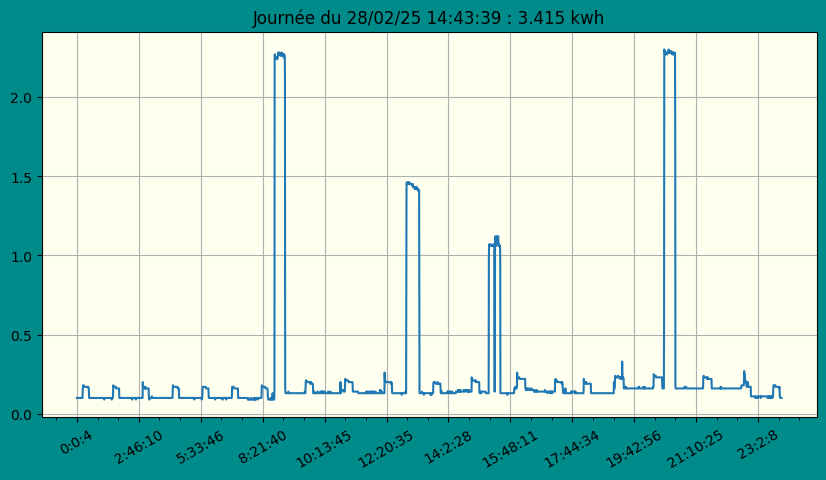

In [536]:
show('28/02/25')

In [537]:
end = time.time()
print(end - start)

35.71368098258972


### 1 kWh window in data of one day
#### df = conso_day

In [538]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
2017099,36942,0.10,36.942,97.450057,49343060743,2025-03-15 00:00:31.526331,15/03/25
2017100,36472,0.10,36.472,98.705857,49343097215,2025-03-15 00:01:07.998331,15/03/25
2017101,33349,0.11,33.349,107.949264,49343130564,2025-03-15 00:01:41.347331,15/03/25
2017102,33154,0.11,33.154,108.584183,49343163718,2025-03-15 00:02:14.501331,15/03/25
2017103,34799,0.10,34.799,103.451249,49343198517,2025-03-15 00:02:49.300331,15/03/25
...,...,...,...,...,...,...,...
2019298,27785,0.13,27.785,129.566313,49395910345,2025-03-15 14:41:21.128331,15/03/25
2019299,27692,0.13,27.692,130.001444,49395938037,2025-03-15 14:41:48.820331,15/03/25
2019300,27809,0.13,27.809,129.454493,49395965846,2025-03-15 14:42:16.629331,15/03/25
2019301,27611,0.13,27.611,130.382818,49395993457,2025-03-15 14:42:44.240331,15/03/25


In [539]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [540]:
df = conso_day
len(df)

2204

In [541]:
period()  # first kWh

2025-03-15 00:00:31.526331	2025-03-15 09:14:30.310331	9h 13m 58s 	1000


In [542]:
period(p=2) # second period

2025-03-15 09:14:30.310331	2025-03-15 13:39:15.204331	4h 24m 44s 	2000


In [543]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.301749
dtype: float64

In [544]:
end = time.time()
print(end - start)

36.173885107040405


## mean for data grouped by days

In [545]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.524089
dtype: float64

In [546]:
last=df_grp.iloc[-1]['kWh']
last

2.204

# conso by date


In [547]:
# select day
day = today

#day = '16/08/24'
day

'15/03/25'

In [548]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
2017099,36942,0.10,36.942,97.450057,49343060743,2025-03-15 00:00:31.526331,15/03/25
2017100,36472,0.10,36.472,98.705857,49343097215,2025-03-15 00:01:07.998331,15/03/25
2017101,33349,0.11,33.349,107.949264,49343130564,2025-03-15 00:01:41.347331,15/03/25
2017102,33154,0.11,33.154,108.584183,49343163718,2025-03-15 00:02:14.501331,15/03/25
2017103,34799,0.10,34.799,103.451249,49343198517,2025-03-15 00:02:49.300331,15/03/25
...,...,...,...,...,...,...,...
2019298,27785,0.13,27.785,129.566313,49395910345,2025-03-15 14:41:21.128331,15/03/25
2019299,27692,0.13,27.692,130.001444,49395938037,2025-03-15 14:41:48.820331,15/03/25
2019300,27809,0.13,27.809,129.454493,49395965846,2025-03-15 14:42:16.629331,15/03/25
2019301,27611,0.13,27.611,130.382818,49395993457,2025-03-15 14:42:44.240331,15/03/25


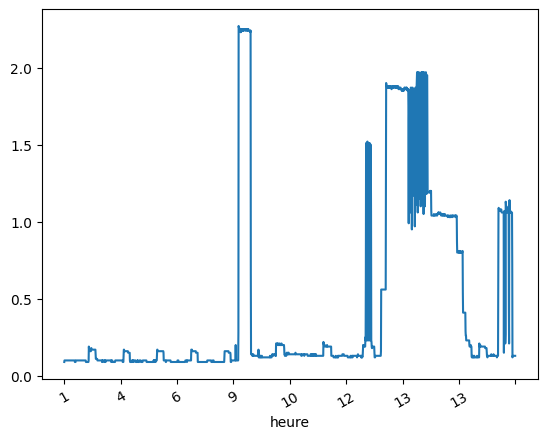

In [549]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [550]:
end = time.time()
print(end - start)

36.98055124282837


### grouped by 'heure'

In [551]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 2017099 to 2019302
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2204 non-null   int64         
 1   kWh        2204 non-null   float64       
 2   sec        2204 non-null   float64       
 3   Wh         2204 non-null   float64       
 4   cumul(ms)  2204 non-null   int64         
 5   dates      2204 non-null   datetime64[ns]
 6   days       2204 non-null   object        
 7   heure      2204 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 155.0+ KB


In [552]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,36942,0.10,36.942,97.450057,49343060743,2025-03-15 00:00:31.526331,15/03/25
0,36472,0.10,36.472,98.705857,49343097215,2025-03-15 00:01:07.998331,15/03/25
0,33349,0.11,33.349,107.949264,49343130564,2025-03-15 00:01:41.347331,15/03/25
0,33154,0.11,33.154,108.584183,49343163718,2025-03-15 00:02:14.501331,15/03/25
0,34799,0.10,34.799,103.451249,49343198517,2025-03-15 00:02:49.300331,15/03/25
...,...,...,...,...,...,...,...
14,27785,0.13,27.785,129.566313,49395910345,2025-03-15 14:41:21.128331,15/03/25
14,27692,0.13,27.692,130.001444,49395938037,2025-03-15 14:41:48.820331,15/03/25
14,27809,0.13,27.809,129.454493,49395965846,2025-03-15 14:42:16.629331,15/03/25


In [553]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [554]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     110
1     109
2     101
3     108
4     108
5     107
6      97
7     107
8     105
9     173
10    151
11    142
12    156
13    473
14    157
Name: kWh, dtype: int64

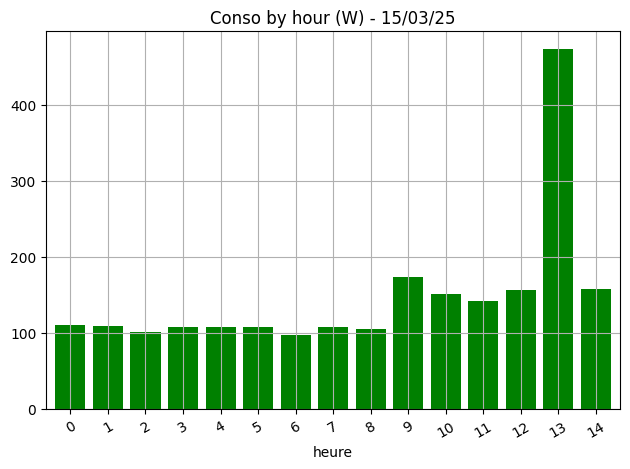

In [555]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [556]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, 21/08/23 to 15/03/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     573 non-null    float64
dtypes: float64(1)
memory usage: 9.0+ KB


In [557]:
# give the periods of 1 kwh in a day
period()

2025-03-15 00:00:31.526331	2025-03-15 09:14:30.310331	9h 13m 58s 	1000


In [558]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-03-15 00:00:31.526331'),
 Timestamp('2025-03-15 09:14:31.910331'))

In [559]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [560]:
df_grp.mean()


kWh    3.524089
dtype: float64

In [561]:
df_grp.head()


,kWh
days,
21/08/23,0.507
22/08/23,3.696
23/08/23,4.242
24/08/23,3.687
25/08/23,3.915


In [562]:
df_grp.tail()


,kWh
days,
11/03/25,3.308
12/03/25,3.368
13/03/25,4.007
14/03/25,3.395
15/03/25,2.204


In [563]:
end = time.time()
print(end - start)

38.09553289413452


# plot les 100 derniers jours


In [564]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.68114
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

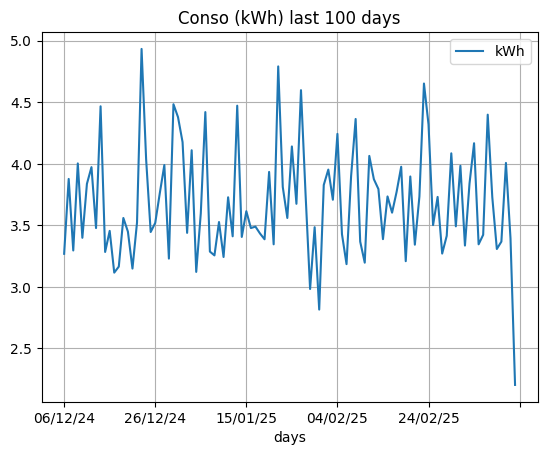

In [565]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [566]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.204
max,4.933


In [567]:
end = time.time()
print(end - start)

38.734142541885376


Text(0.5, 1.0, 'Last month conso by day')

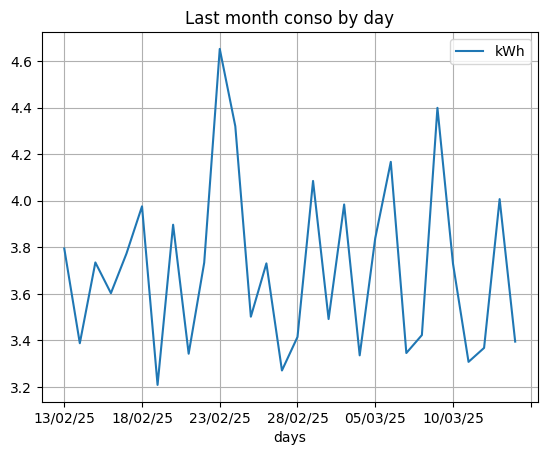

In [568]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.grid()
plt.title('Last month conso by day')


In [569]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 23/02/25 4.652
Min : 19/02/25 3.209


In [570]:

tranches = len(df)//1000
tranches+1


3

In [571]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-03-15 00:00:31.526331	2025-03-15 09:14:30.310331	9h 13m 58s 	1000
2025-03-15 09:14:30.310331	2025-03-15 13:39:15.204331	4h 24m 44s 	2000
2025-03-15 13:39:15.204331	2025-03-15 14:43:11.700331	1h 3m 56s 	204


('14:43:39', 2.204, 2204)

In [572]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2204 entries, 2017099 to 2019302
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   2204 non-null   int64         
 1   kWh        2204 non-null   float64       
 2   sec        2204 non-null   float64       
 3   Wh         2204 non-null   float64       
 4   cumul(ms)  2204 non-null   int64         
 5   dates      2204 non-null   datetime64[ns]
 6   days       2204 non-null   object        
 7   heure      2204 non-null   object        
 8   hours      2204 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 172.2+ KB


In [573]:
conso_hours['heure'], conso_hours['hours']

(2017099     0
 2017100     0
 2017101     0
 2017102     0
 2017103     0
            ..
 2019298    14
 2019299    14
 2019300    14
 2019301    14
 2019302    14
 Name: heure, Length: 2204, dtype: object,
 2017099    00
 2017100    00
 2017101    00
 2017102    00
 2017103    00
            ..
 2019298    14
 2019299    14
 2019300    14
 2019301    14
 2019302    14
 Name: hours, Length: 2204, dtype: object)

In [574]:
end = time.time()
print(end - start)

39.44908380508423


# select number of days to display


In [575]:
span = 30
#df_grp.tail(span)

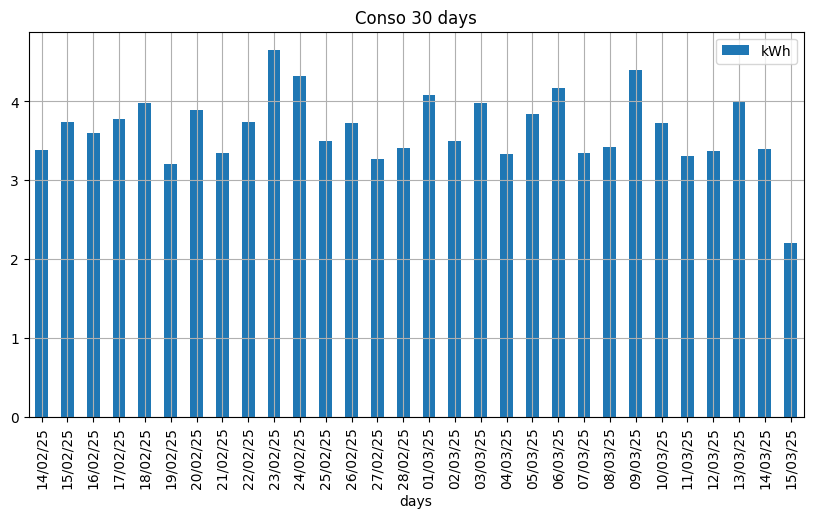

In [576]:

# Plot the figure without labels
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight') 
plt.title(f'Conso {span} days')
plt.xticks(rotation=90);


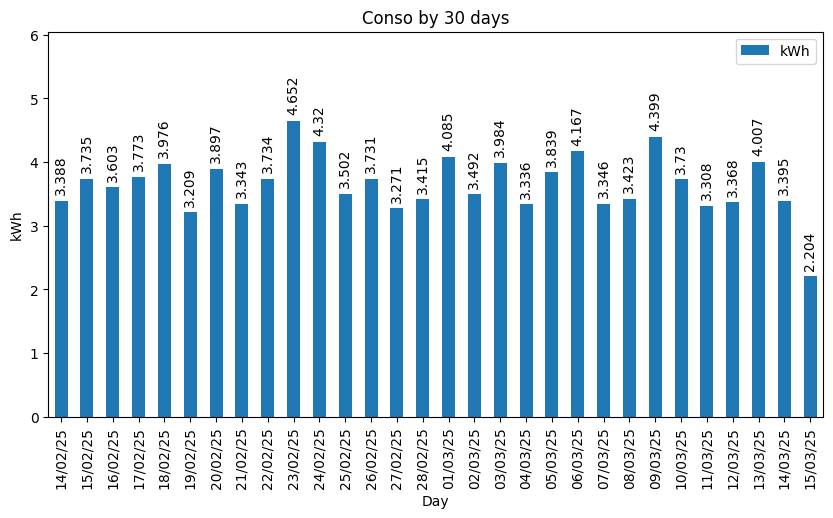

In [577]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
ax.set_title(f"Conso by {span} days")
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [578]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
14/02/25    3.388
15/02/25    3.735
16/02/25    3.603
17/02/25    3.773
18/02/25    3.976
19/02/25    3.209
20/02/25    3.897
21/02/25    3.343
22/02/25    3.734
23/02/25    4.652
24/02/25    4.320
25/02/25    3.502
26/02/25    3.731
27/02/25    3.271
28/02/25    3.415
01/03/25    4.085
02/03/25    3.492
03/03/25    3.984
04/03/25    3.336
05/03/25    3.839
06/03/25    4.167
07/03/25    3.346
08/03/25    3.423
09/03/25    4.399
10/03/25    3.730
11/03/25    3.308
12/03/25    3.368
13/03/25    4.007
14/03/25    3.395
15/03/25    2.204
Name: kWh, dtype: float64

In [579]:
x_labels=df_grp.tail(span).index
x_labels

Index(['14/02/25', '15/02/25', '16/02/25', '17/02/25', '18/02/25', '19/02/25',
       '20/02/25', '21/02/25', '22/02/25', '23/02/25', '24/02/25', '25/02/25',
       '26/02/25', '27/02/25', '28/02/25', '01/03/25', '02/03/25', '03/03/25',
       '04/03/25', '05/03/25', '06/03/25', '07/03/25', '08/03/25', '09/03/25',
       '10/03/25', '11/03/25', '12/03/25', '13/03/25', '14/03/25', '15/03/25'],
      dtype='object', name='days')

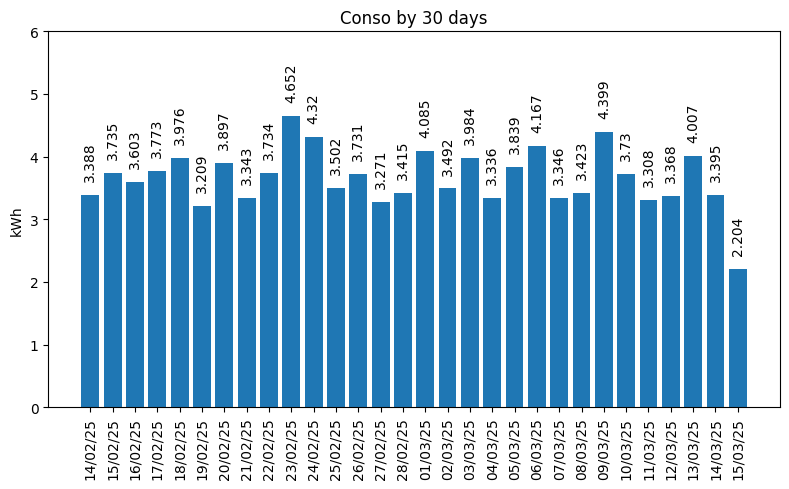

In [580]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
ax.set(ylabel='kWh', title=f'Conso by {span} days', ylim=(0, 6))
plt.xticks(rotation=90);


In [581]:
end = time.time()
print(end - start)

42.41038489341736


In [582]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

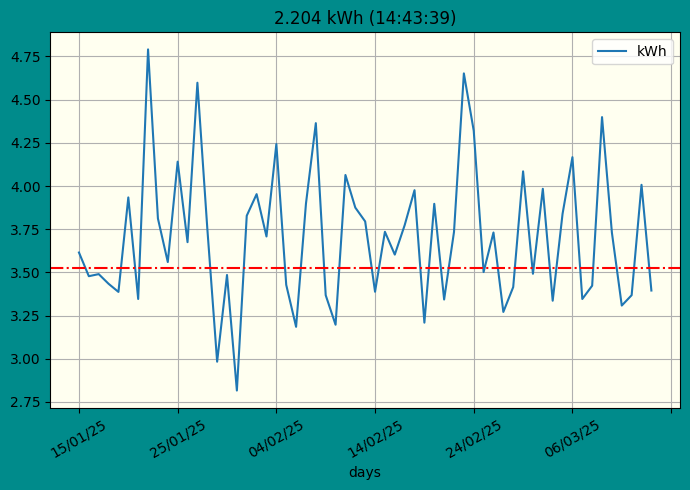

In [583]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")


df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=np.nanmean(df_grp),c='red', ls='-.')
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

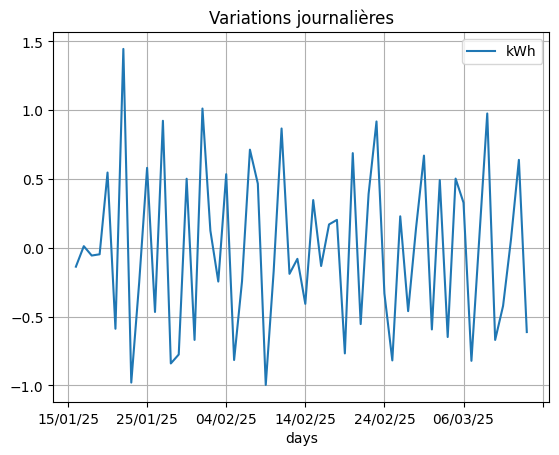

In [584]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [585]:
end = time.time()
print(end - start)

43.71426868438721


# Data from 21/08/23

In [586]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:36:32.717331,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:36:54.575331,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:37:16.576331,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:37:38.504331,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:38:00.395331,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
2019298,27785,0.13,27.785,129.566313,49395910345,2025-03-15 14:41:21.128331,15/03/25,14,2025-03,15
2019299,27692,0.13,27.692,130.001444,49395938037,2025-03-15 14:41:48.820331,15/03/25,14,2025-03,15
2019300,27809,0.13,27.809,129.454493,49395965846,2025-03-15 14:42:16.629331,15/03/25,14,2025-03,15
2019301,27611,0.13,27.611,130.382818,49395993457,2025-03-15 14:42:44.240331,15/03/25,14,2025-03,15


In [587]:
end = time.time()
print(end - start)

111.08546662330627


In [588]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03', '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03'])

In [589]:
month=conso_grouped_by_month.get_group('2024-11')

In [590]:
conso_grouped_by_month_day = month.groupby(['day'], sort=False)

<Axes: xlabel='day'>

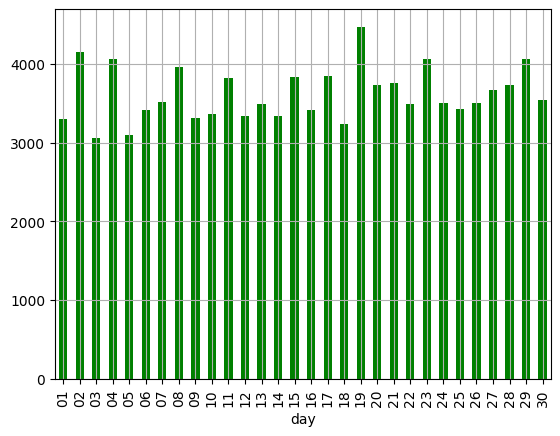

In [591]:
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

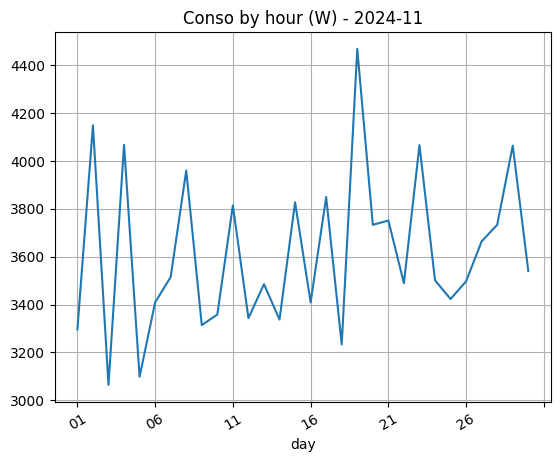

In [592]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [593]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

In [594]:
conso_grouped_by_month_day.count()

,hours,months,kWh
day,,,
01,3296,3296,3296
02,4149,4149,4149
03,3064,3064,3064
04,4067,4067,4067
05,3098,3098,3098
06,3409,3409,3409
07,3515,3515,3515
08,3960,3960,3960
09,3314,3314,3314


In [595]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [596]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [597]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2023-08,38416,38416,38416
2023-09,116326,116326,116326
2023-10,112861,112861,112861
2023-11,113608,113608,113608
2023-12,123301,123301,123301
2024-01,119519,119519,119519
2024-02,108755,108755,108755
2024-03,114276,114276,114276
2024-04,109930,109930,109930


In [598]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [599]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [600]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
21/08/23,507
22/08/23,3696
23/08/23,4242
24/08/23,3687
25/08/23,3915
...,...
11/03/25,3308
12/03/25,3368
13/03/25,4007


In [601]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,21934,0.16,21.934,164.128750,21934,2023-08-21 21:36:32.717331,21/08/23,21,2023-08,21
1,21858,0.16,21.858,164.699424,43792,2023-08-21 21:36:54.575331,21/08/23,21,2023-08,21
2,22001,0.16,22.001,163.628926,65793,2023-08-21 21:37:16.576331,21/08/23,21,2023-08,21
3,21928,0.16,21.928,164.173659,87721,2023-08-21 21:37:38.504331,21/08/23,21,2023-08,21
4,21891,0.16,21.891,164.451144,109612,2023-08-21 21:38:00.395331,21/08/23,21,2023-08,21
...,...,...,...,...,...,...,...,...,...,...
2019298,27785,0.13,27.785,129.566313,49395910345,2025-03-15 14:41:21.128331,15/03/25,14,2025-03,15
2019299,27692,0.13,27.692,130.001444,49395938037,2025-03-15 14:41:48.820331,15/03/25,14,2025-03,15
2019300,27809,0.13,27.809,129.454493,49395965846,2025-03-15 14:42:16.629331,15/03/25,14,2025-03,15
2019301,27611,0.13,27.611,130.382818,49395993457,2025-03-15 14:42:44.240331,15/03/25,14,2025-03,15


In [602]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                              
21/08/23 21    0        21/08/23    21  0.16
               1        21/08/23    21  0.16
               2        21/08/23    21  0.16
               3        21/08/23    21  0.16
               4        21/08/23    21  0.16
...                          ...   ...   ...
15/03/25 14    2019298  15/03/25    14  0.13
               2019299  15/03/25    14  0.13
               2019300  15/03/25    14  0.13
               2019301  15/03/25    14  0.13
               2019302  15/03/25    14  0.13

[2019303 rows x 3 columns]

In [603]:
groupallbyday.indices.keys()

dict_keys(['21/08/23', '22/08/23', '23/08/23', '24/08/23', '25/08/23', '26/08/23', '27/08/23', '28/08/23', '29/08/23', '30/08/23', '31/08/23', '01/09/23', '02/09/23', '03/09/23', '04/09/23', '05/09/23', '06/09/23', '07/09/23', '08/09/23', '09/09/23', '10/09/23', '11/09/23', '12/09/23', '13/09/23', '14/09/23', '15/09/23', '16/09/23', '17/09/23', '18/09/23', '19/09/23', '20/09/23', '21/09/23', '22/09/23', '23/09/23', '24/09/23', '25/09/23', '26/09/23', '27/09/23', '28/09/23', '29/09/23', '30/09/23', '01/10/23', '02/10/23', '03/10/23', '04/10/23', '05/10/23', '06/10/23', '07/10/23', '08/10/23', '09/10/23', '10/10/23', '11/10/23', '12/10/23', '13/10/23', '14/10/23', '15/10/23', '16/10/23', '17/10/23', '18/10/23', '19/10/23', '20/10/23', '21/10/23', '22/10/23', '23/10/23', '24/10/23', '25/10/23', '26/10/23', '27/10/23', '28/10/23', '29/10/23', '30/10/23', '31/10/23', '01/11/23', '02/11/23', '03/11/23', '04/11/23', '05/11/23', '06/11/23', '07/11/23', '08/11/23', '09/11/23', '10/11/23', '11/1

In [604]:
groupallbydayhours.indices.keys()

dict_keys([('21/08/23', '21'), ('21/08/23', '22'), ('21/08/23', '23'), ('22/08/23', '21'), ('22/08/23', '22'), ('22/08/23', '23'), ('22/08/23', '00'), ('22/08/23', '01'), ('22/08/23', '02'), ('22/08/23', '03'), ('22/08/23', '04'), ('22/08/23', '05'), ('22/08/23', '06'), ('22/08/23', '07'), ('22/08/23', '08'), ('22/08/23', '09'), ('22/08/23', '10'), ('22/08/23', '11'), ('22/08/23', '12'), ('22/08/23', '13'), ('22/08/23', '14'), ('22/08/23', '15'), ('22/08/23', '16'), ('22/08/23', '17'), ('22/08/23', '18'), ('22/08/23', '19'), ('22/08/23', '20'), ('23/08/23', '21'), ('23/08/23', '22'), ('23/08/23', '23'), ('23/08/23', '00'), ('23/08/23', '01'), ('23/08/23', '02'), ('23/08/23', '03'), ('23/08/23', '04'), ('23/08/23', '05'), ('23/08/23', '06'), ('23/08/23', '07'), ('23/08/23', '08'), ('23/08/23', '09'), ('23/08/23', '10'), ('23/08/23', '11'), ('23/08/23', '12'), ('23/08/23', '13'), ('23/08/23', '14'), ('23/08/23', '15'), ('23/08/23', '16'), ('23/08/23', '17'), ('23/08/23', '18'), ('23/08/2

In [605]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
21/08/23,507,507
22/08/23,3696,3696
23/08/23,4242,4242
24/08/23,3687,3687
25/08/23,3915,3915
...,...,...
11/03/25,3308,3308
12/03/25,3368,3368
13/03/25,4007,4007


In [606]:
grp_by_day['kWh'].cumsum()

days
21/08/23        507
22/08/23       4203
23/08/23       8445
24/08/23      12132
25/08/23      16047
             ...   
11/03/25    2006329
12/03/25    2009697
13/03/25    2013704
14/03/25    2017099
15/03/25    2019303
Name: kWh, Length: 573, dtype: int64

In [607]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
21/08/23 21      65
         22     282
         23     160
22/08/23 00     132
         01     132
...             ...
15/03/25 10     151
         11     142
         12     156
         13     473
         14     157

[13722 rows x 1 columns]

In [608]:
grp_by_dayhours['kWh'].cumsum()

days      hours
21/08/23  21            65
          22           347
          23           507
22/08/23  00           639
          01           771
                    ...   
15/03/25  10       2018375
          11       2018517
          12       2018673
          13       2019146
          14       2019303
Name: kWh, Length: 13722, dtype: int64

In [609]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum   diff
days     hours                    
21/08/23 21      65      65    NaN
         22     282     347  217.0
         23     160     507 -122.0
22/08/23 00     132     132    NaN
         01     132     264    0.0
...             ...     ...    ...
15/03/25 10     151    1276  -22.0
         11     142    1418   -9.0
         12     156    1574   14.0
         13     473    2047  317.0
         14     157    2204 -316.0

[13722 rows x 3 columns]

In [610]:
today, grp_by_dayhours.loc[today]

('15/03/25',
        kWh  cumsum   diff
 hours                    
 00     110     110    NaN
 01     109     219   -1.0
 02     101     320   -8.0
 03     108     428    7.0
 04     108     536    0.0
 05     107     643   -1.0
 06      97     740  -10.0
 07     107     847   10.0
 08     105     952   -2.0
 09     173    1125   68.0
 10     151    1276  -22.0
 11     142    1418   -9.0
 12     156    1574   14.0
 13     473    2047  317.0
 14     157    2204 -316.0)

Text(0.5, 1.0, 'Cumul journalier')

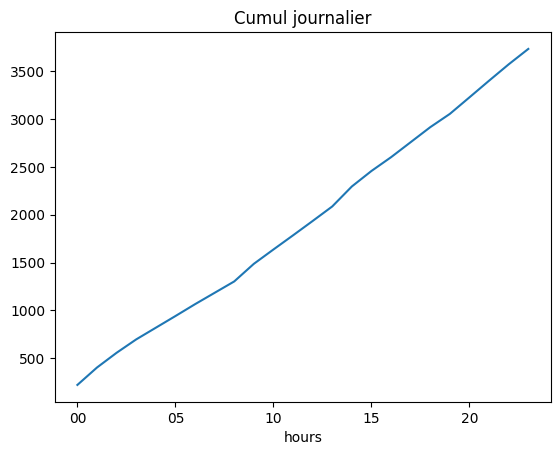

In [611]:
# progression sans surprise
grp_by_dayhours.loc['26/08/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

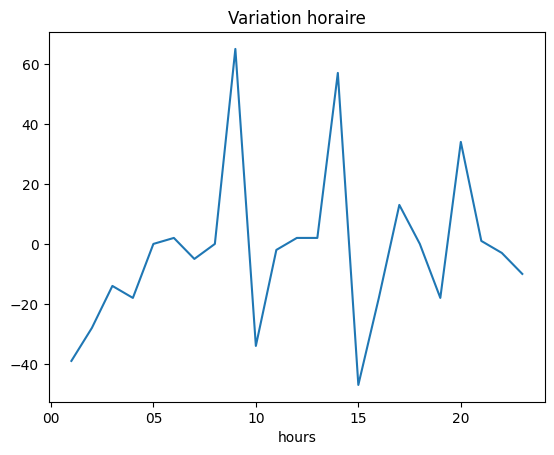

In [612]:
# plus parlant
grp_by_dayhours.loc['26/08/24']['diff'].plot()
plt.title(r'Variation horaire')

In [613]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

573

In [614]:
df_grp.tail(n)['kWh'].describe()


count    573.000000
mean       3.524089
std        0.661900
min        0.507000
25%        3.349000
50%        3.623000
75%        3.896000
max        4.963000
Name: kWh, dtype: float64

In [615]:
maxday = df_grp.tail(n)['kWh'].idxmax()

Text(0.5, 1.0, '573 days')

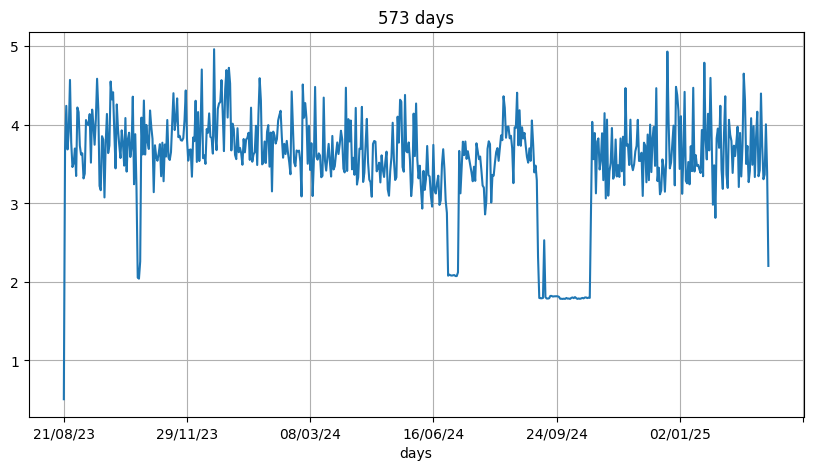

In [616]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

Text(0.5, 1.0, '400 days')

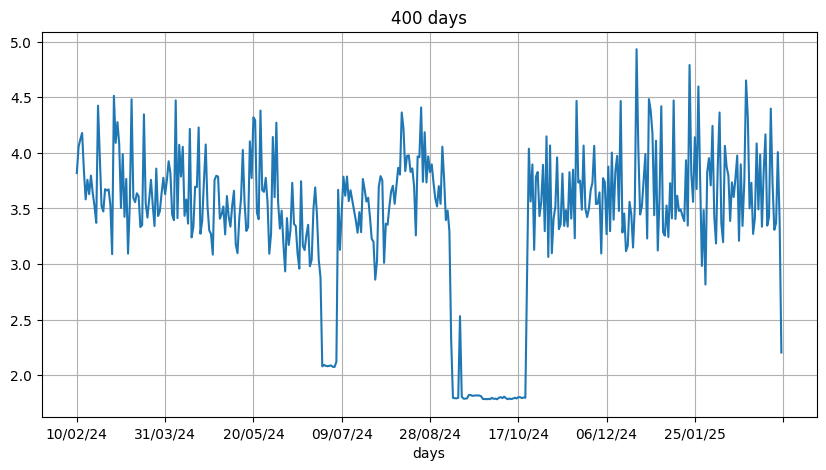

In [617]:
# show conso in span 
span = 400
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')

In [618]:
df_grp['kWh']

days
21/08/23    0.507
22/08/23    3.696
23/08/23    4.242
24/08/23    3.687
25/08/23    3.915
            ...  
11/03/25    3.308
12/03/25    3.368
13/03/25    4.007
14/03/25    3.395
15/03/25    2.204
Name: kWh, Length: 573, dtype: float64

In [619]:
df_grp.describe()

,kWh
count,573.000000
mean,3.524089
std,0.661900
min,0.507000
25%,3.349000
50%,3.623000
75%,3.896000
max,4.963000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

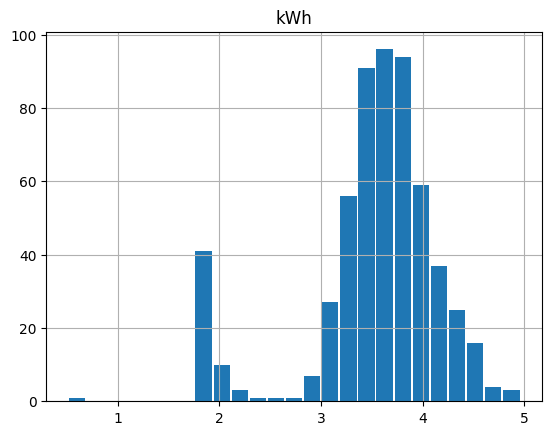

In [620]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [621]:
df_grp.tail(span)['kWh']

days
10/02/24    3.819
11/02/24    4.056
12/02/24    4.123
13/02/24    4.179
14/02/24    3.843
            ...  
11/03/25    3.308
12/03/25    3.368
13/03/25    4.007
14/03/25    3.395
15/03/25    2.204
Name: kWh, Length: 400, dtype: float64

# Conso par heure

In [622]:
day

'15/03/25'

In [623]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,110,110,NaN
01,109,219,-1.0
02,101,320,-8.0
03,108,428,7.0
04,108,536,0.0
05,107,643,-1.0
06,97,740,-10.0
07,107,847,10.0
08,105,952,-2.0


In [624]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


15

In [625]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 16)

In [626]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [627]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15.])

In [628]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
Name: days, dtype: float64

In [629]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [630]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 00 to 14
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     15 non-null     int64  
 1   cumsum  15 non-null     int64  
 2   diff    14 non-null     float64
 3   days    15 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 600.0+ bytes


In [631]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
Name: days, dtype: float64

In [632]:
day

'15/03/25'

In [633]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,110,110,NaN,1.0
01,109,219,-1.0,2.0
02,101,320,-8.0,3.0
03,108,428,7.0,4.0
04,108,536,0.0,5.0
05,107,643,-1.0,6.0
06,97,740,-10.0,7.0
07,107,847,10.0,8.0
08,105,952,-2.0,9.0


Text(0.5, 1.0, '15/03/25')

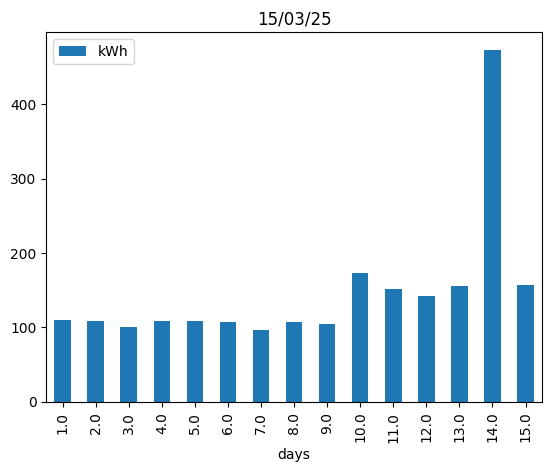

In [634]:
grp_by_dayhours.loc[day][['days','kWh']].plot.bar(x='days')
plt.title(f'{day}')

In [635]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14'],
      dtype='object', name='hours')

# Conso du jour


In [636]:

grp_by_dayhours.count()

kWh       13722
cumsum    13722
diff      13149
days         15
dtype: int64

In [637]:
day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh

hours
00    152
01    165
02    153
03    165
04    168
05    151
06    166
07    147
08    119
09    131
10    114
11    130
12    131
13    114
14    131
15    184
16    153
17    154
18    948
19    188
20    284
21    310
22    302
23    303
Name: kWh, dtype: int64

In [638]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

            kWh
days           
15/03/25  2.204


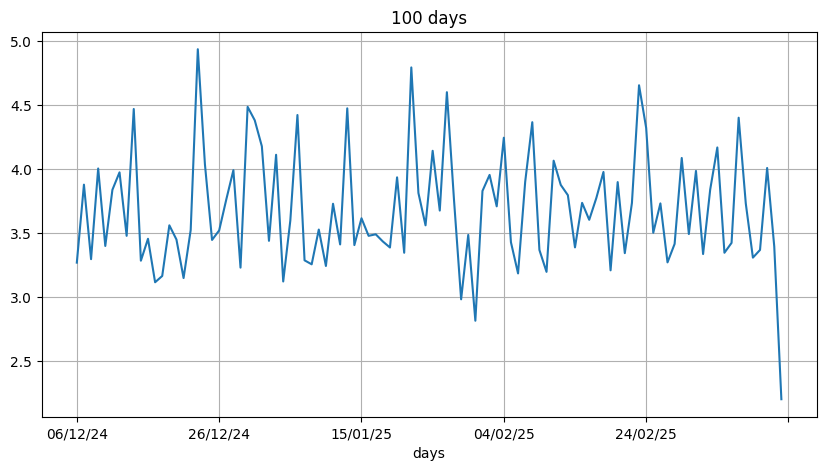

In [639]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.title(f'{span} days')
sum(df_grp.tail(span)['kWh'])
print(df_grp.tail(1))

In [640]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

141.6144871711731


# Today

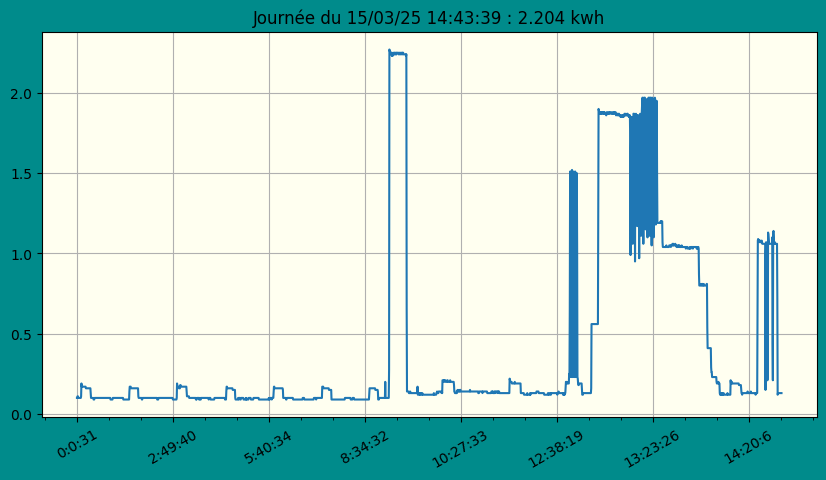

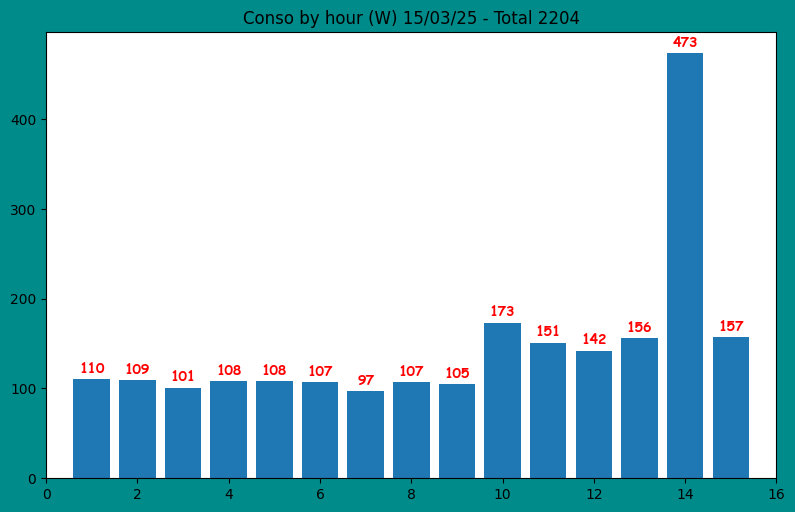

In [641]:
show(today,bgcolor='ivory')
conso_by_hour(today)

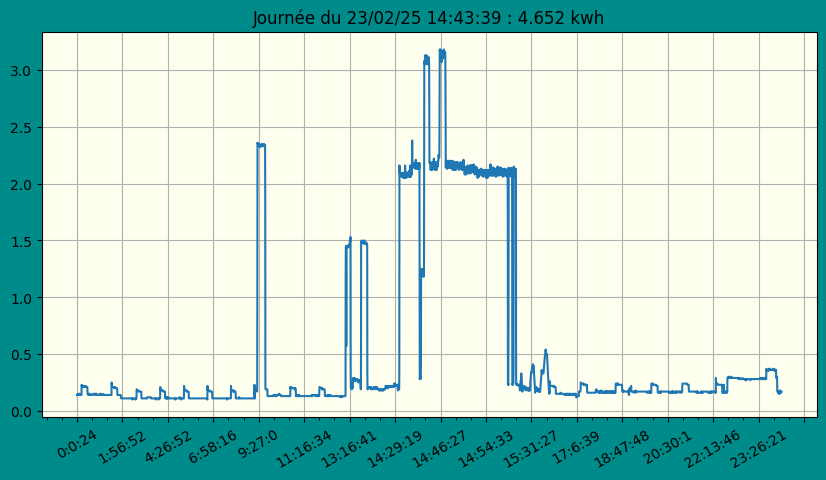

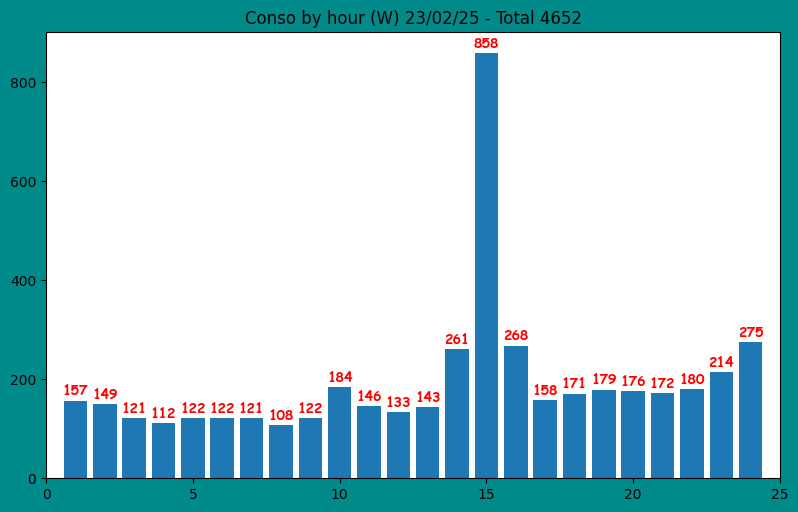

In [642]:
day = '23/02/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

21/12/23


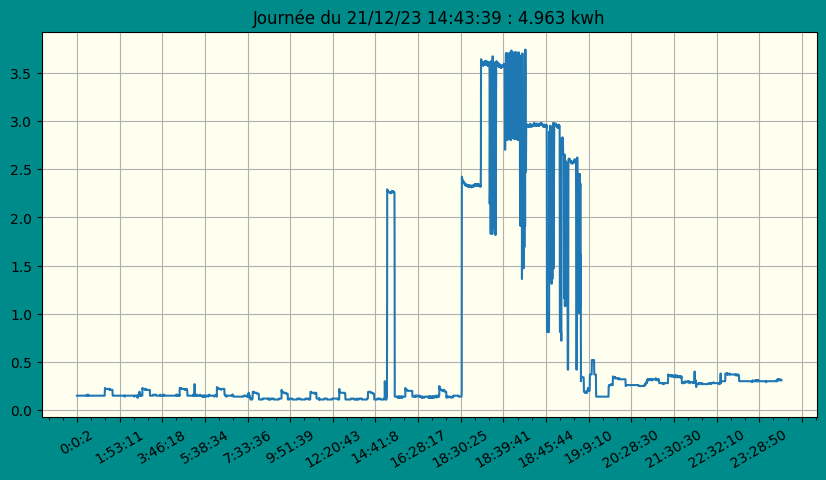

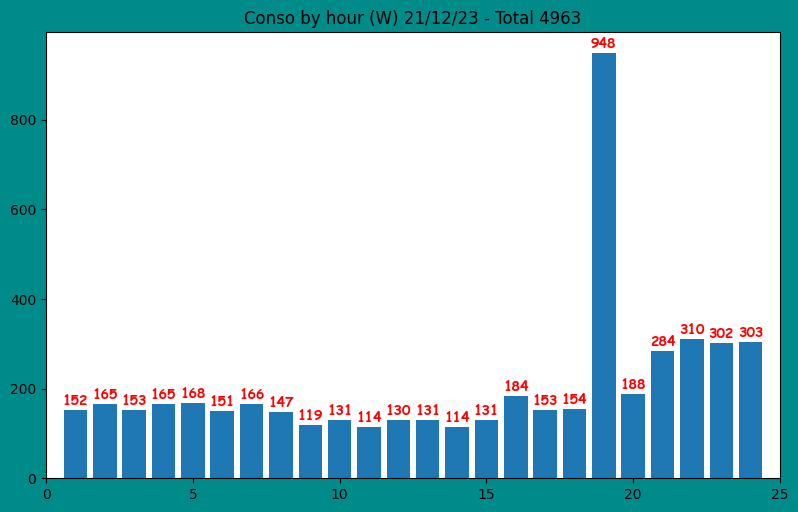

In [643]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day)

In [644]:
sum(data)

4963

In [645]:
diff = grp_by_dayhours.loc[today]
diff


,kWh,cumsum,diff,days
hours,,,,
00,110,110,NaN,1.0
01,109,219,-1.0,2.0
02,101,320,-8.0,3.0
03,108,428,7.0,4.0
04,108,536,0.0,5.0
05,107,643,-1.0,6.0
06,97,740,-10.0,7.0
07,107,847,10.0,8.0
08,105,952,-2.0,9.0


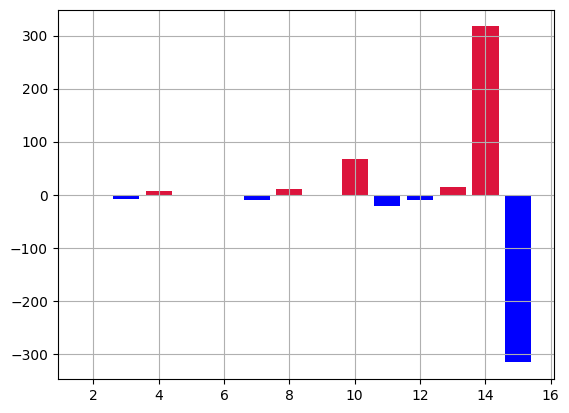

In [646]:
x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

In [647]:
data

hours
00    152
01    165
02    153
03    165
04    168
05    151
06    166
07    147
08    119
09    131
10    114
11    130
12    131
13    114
14    131
15    184
16    153
17    154
18    948
19    188
20    284
21    310
22    302
23    303
Name: kWh, dtype: int64

<Axes: xlabel='hours'>

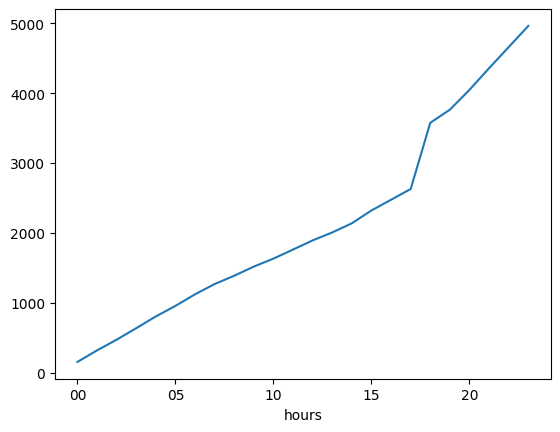

In [648]:
data.cumsum().plot()


<Axes: xlabel='hours'>

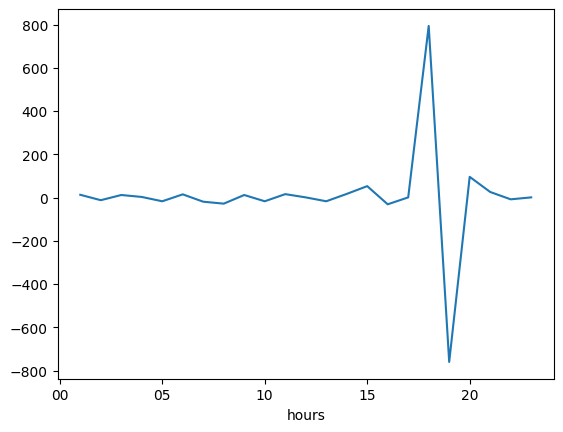

In [649]:
# evolution par heure
data.diff().plot()

In [650]:
data.diff().describe()

count     23.000000
mean       6.565217
std      235.889579
min     -760.000000
25%      -17.000000
50%        1.000000
75%       15.500000
max      794.000000
Name: kWh, dtype: float64

<Axes: >

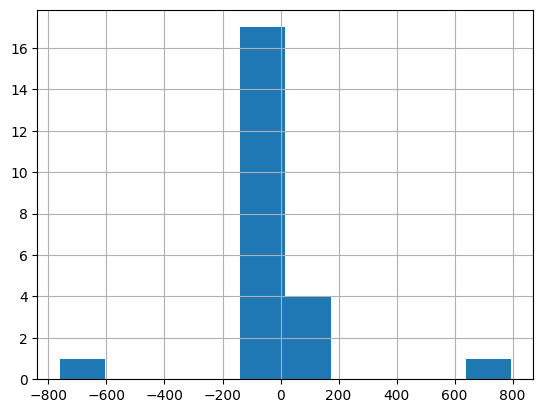

In [651]:
data.diff().hist()

# Test sauvegarde

In [652]:
import os
os.listdir(path='.')

['.git',
 '.gitignore',
 '.git_old',
 '.ipynb_checkpoints',
 '1row.flf',
 '5_days_meteo.ipynb',
 '8days.csv',
 '8days.pkl',
 '8days_dump.json',
 '8days_to_json.json',
 'advanced_expression.ipynb',
 'alphabeta_tree.ipynb',
 'amlich.ipynb',
 'amlich5.ipynb',
 'amlich5_test.ipynb',
 'amlich_data.py',
 'amlich_functions.py',
 'amlich_lib.py',
 'amlich_soc_tiet.ipynb',
 'AntPath.ipynb',
 'Apple.csv',
 'astronomie_def.ipynb',
 'atom_electronic_configuration.ipynb',
 'average_binding_energy_by_nucleons.ipynb',
 'bar_label.ipynb',
 'bell_curve.ipynb',
 'bitcoin_api.ipynb',
 'bitmap_convert.ipynb',
 'bitmap_structure.ipynb',
 'CAC40.csv',
 'chess_board.ipynb',
 'coindesk_api_client.ipynb',
 'collections.ipynb',
 'colormaps.ipynb',
 'conso.txt',
 'conso_by_hour.ipynb',
 'conso_data.csv',
 'conso_day_from_20230821.csv',
 'conso_jour.csv',
 'conso_jour.png',
 'conso_kwh.ipynb',
 'conso_kwh_mini.ipynb',
 'conso_kwh_reduced.ipynb',
 'conso_par_jour.csv',
 'covid19_france.ipynb',
 'cryptography_ferne

In [653]:
# list to store files
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

8days.csv
Apple.csv
CAC40.csv
conso_data.csv
conso_day_from_20230821.csv
conso_jour.csv
conso_par_jour.csv
data_temp16122022.csv
demain.csv
df.csv
df_grp.csv
DowJones.csv
EURUSD.csv
Ford.csv
karaoke.csv
ligue1_2020_27.csv
Nasdaq.csv
Nikkei.csv
planete.csv
saturn_bodies.csv
saturn_rings.csv
SMSSpamCollection.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
temp_humidity.csv
Tesla.csv
titanic.csv
Toyota.csv
VNDUSD.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
week.csv


In [654]:
#conso_byhour(day)

In [655]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


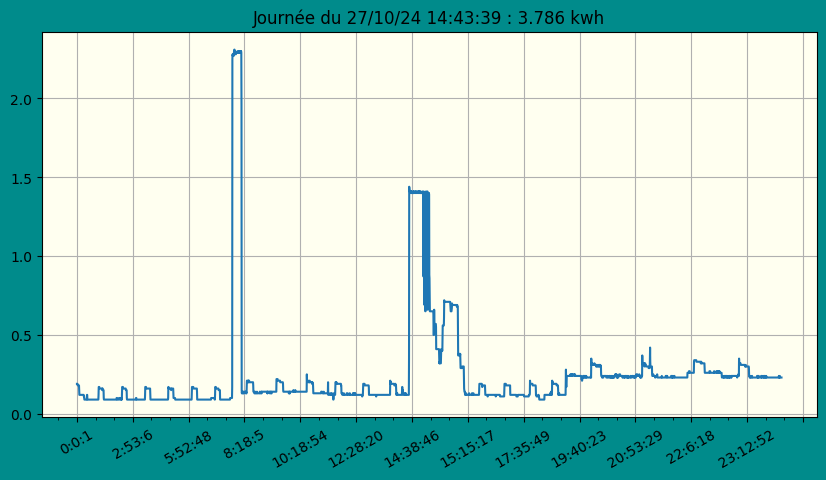

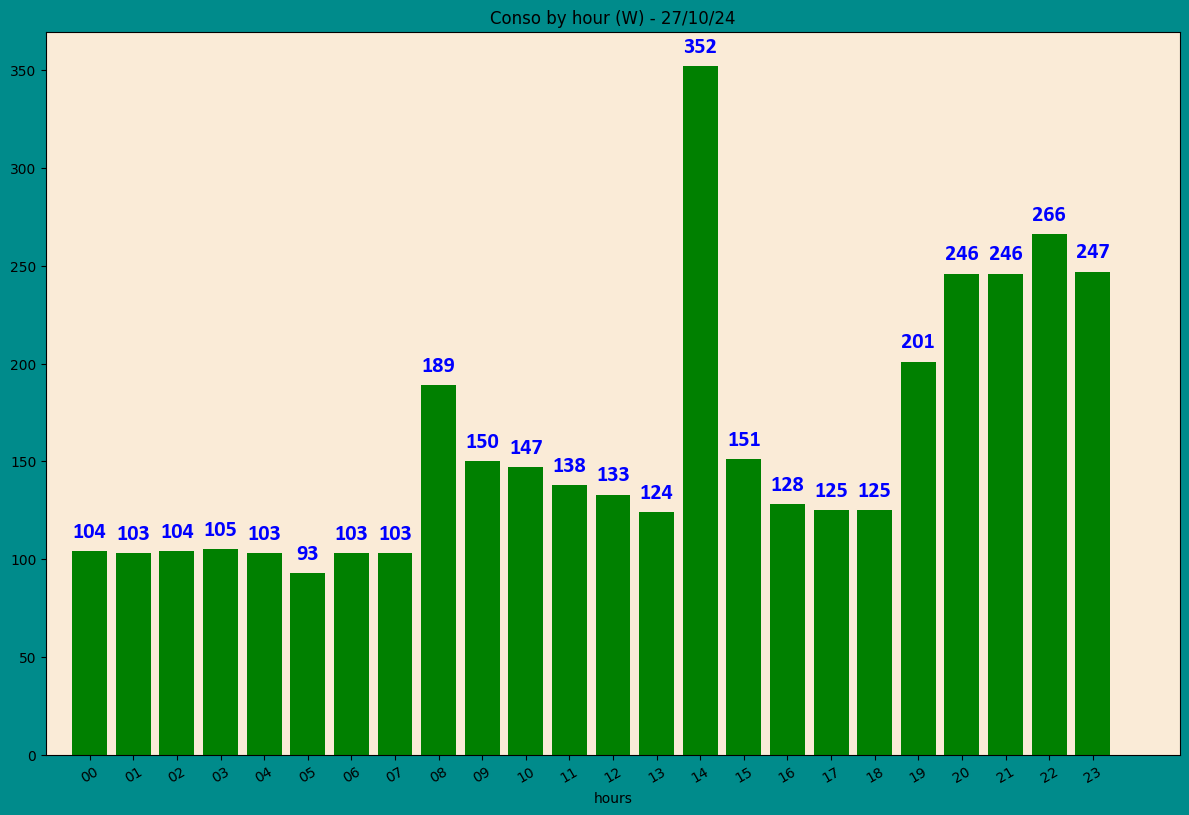

In [656]:
day = '27/10/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [657]:
month.describe()


,kWh
count,108456.000000
mean,0.334559
std,0.564554
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.730000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

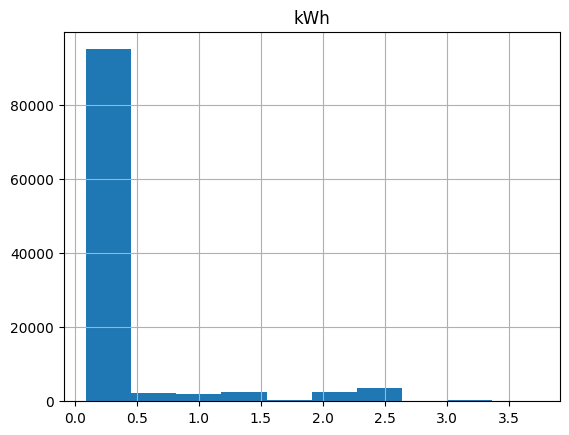

In [658]:
month.hist()

<Axes: >

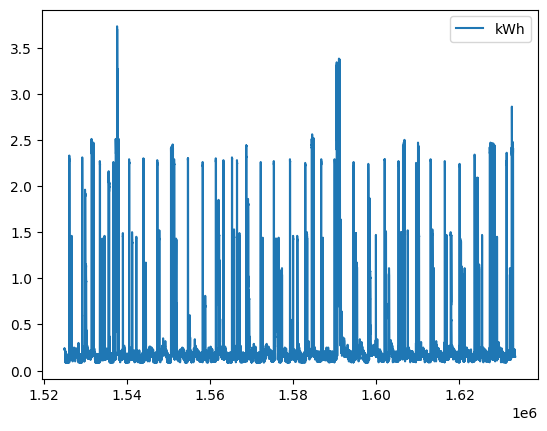

In [659]:
month.plot()

In [660]:
# index with max conso in this month
month.idxmax().kWh

1537642

In [661]:
# plot month day max conso (télévision de 11h à 23h)
day = month.idxmax()
#day = '27/10/2024'
day

day       1629855
hours     1528070
months    1524939
kWh       1537642
dtype: int64

In [662]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [663]:
grp_by_dayhours

kWh  cumsum   diff  days
days     hours                          
21/08/23 21      65      65    NaN   NaN
         22     282     347  217.0   NaN
         23     160     507 -122.0   NaN
22/08/23 00     132     132    NaN   NaN
         01     132     264    0.0   NaN
...             ...     ...    ...   ...
15/03/25 10     151    1276  -22.0  11.0
         11     142    1418   -9.0  12.0
         12     156    1574   14.0  13.0
         13     473    2047  317.0  14.0
         14     157    2204 -316.0  15.0

[13722 rows x 4 columns]

In [664]:
month

,day,hours,months,kWh
1524939,01,00,2024-11,0.23
1524940,01,00,2024-11,0.23
1524941,01,00,2024-11,0.23
1524942,01,00,2024-11,0.23
1524943,01,00,2024-11,0.23
...,...,...,...,...
1633390,30,23,2024-11,0.15
1633391,30,23,2024-11,0.15
1633392,30,23,2024-11,0.15
1633393,30,23,2024-11,0.15


In [665]:
month.idxmax()


day       1629855
hours     1528070
months    1524939
kWh       1537642
dtype: int64

In [666]:
month.loc[month.idxmax().kWh]


day            04
hours          13
months    2024-11
kWh          3.73
Name: 1537642, dtype: object

In [667]:
grp_by_dayhours.loc[['28/02/25']].idxmax()

C:\Users\jean\AppData\Local\Temp\ipykernel_5000\4095454801.py:1: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  grp_by_dayhours.loc[['28/02/25']].idxmax()


kWh       (28/02/25, 20)
cumsum    (28/02/25, 23)
diff      (28/02/25, 13)
days                 NaN
dtype: object

In [668]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [669]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [670]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [671]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB